In [15]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.multioutput import MultiOutputClassifier
from google.colab import drive
from IPython.display import display, HTML
import ipywidgets as widgets

# Mount Google Drive
drive.mount('/content/drive')

# Set the directory path
data_dir = '/content/drive/MyDrive/NLP_ToxicComments'

# Load data
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'))
test_labels_df = pd.read_csv(os.path.join(data_dir, 'test_labels.csv'))

# Check data
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("Test labels shape:", test_labels_df.shape)

# Define toxic columns
toxic_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Print class distribution
print("\nClass distribution in training data:")
for col in toxic_columns:
    count = train_df[col].sum()
    percentage = (count / len(train_df)) * 100
    print(f"{col}: {count} ({percentage:.2f}%)")

# Text cleaning function - preserve more signal for toxicity
def clean_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    else:
        return ""

# Apply cleaning - less aggressive to preserve toxic signals
train_df['cleaned_comment'] = train_df['comment_text'].apply(clean_text)
test_df['cleaned_comment'] = test_df['comment_text'].apply(clean_text)

# Create is_toxic column
train_df['is_toxic'] = train_df[toxic_columns].sum(axis=1) > 0

# Address class imbalance - oversample toxic examples
from sklearn.utils import resample

# Separate majority and minority classes
train_majority = train_df[train_df['is_toxic'] == 0]
train_minority = train_df[train_df['is_toxic'] == 1]

# Upsample minority class
train_minority_upsampled = resample(train_minority,
                                    replace=True,     # sample with replacement
                                    n_samples=len(train_majority),    # to match majority class
                                    random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_majority, train_minority_upsampled])

print(f"Original dataset shape: {train_df.shape}")
print(f"Upsampled dataset shape: {train_upsampled.shape}")
print(f"New class distribution: {train_upsampled['is_toxic'].value_counts()}")

# TF-IDF Vectorization with more features
tfidf_vectorizer = TfidfVectorizer(
    max_features=30000,    # Increased from 20000
    min_df=3,              # Reduced to capture more toxic terms
    max_df=0.9,            # Increased to include more common terms
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 3),    # Include up to 3-grams to capture phrases
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True
)

# Split data using the balanced dataset
X_train = train_upsampled['cleaned_comment']
y_train = train_upsampled[toxic_columns]

X_val = train_df[~train_df.index.isin(train_upsampled.index)]['cleaned_comment']
y_val = train_df[~train_df.index.isin(train_upsampled.index)][toxic_columns]

if len(X_val) < 1000:  # If not enough validation data
    # Use original split method
    X_train, X_val, y_train, y_val = train_test_split(
        train_df['cleaned_comment'],
        train_df[toxic_columns],
        test_size=0.2,
        random_state=42,
        stratify=train_df['is_toxic']
    )

# Transform data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
print(f"TF-IDF features shape: {X_train_tfidf.shape}")

# Train Logistic Regression model with adjusted parameters
print("Training logistic regression model...")
baseline_model = MultiOutputClassifier(
    LogisticRegression(C=1, solver='sag', random_state=42, max_iter=300, class_weight='balanced')
)
baseline_model.fit(X_train_tfidf, y_train)
print("Baseline model training completed!")

# Make predictions on validation data
y_val_pred = baseline_model.predict(X_val_tfidf)
y_val_pred_proba = np.array([estimator.predict_proba(X_val_tfidf)[:, 1] for estimator in baseline_model.estimators_]).T

# Calculate ROC AUC
def roc_auc_score(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    return auc(fpr, tpr)

# Evaluate model
print("\nModel Evaluation on Validation Data:")
for i, column in enumerate(toxic_columns):
    auc_score = roc_auc_score(y_val[column], y_val_pred_proba[:, i])
    print(f"{column}: ROC AUC = {auc_score:.4f}")

# Adjust weights for scoring - give more weight to severe categories
category_weights = {
    'toxic': 1.0,
    'severe_toxic': 2.0,  # Higher weight
    'obscene': 1.5,
    'threat': 2.0,        # Higher weight
    'insult': 1.2,
    'identity_hate': 2.0  # Higher weight
}

# Function to make predictions with adjusted weights
def predict_toxicity(comment, model=baseline_model, vectorizer=tfidf_vectorizer, weights=category_weights):
    cleaned = clean_text(comment)
    features = vectorizer.transform([cleaned])

    probas = np.array([estimator.predict_proba(features)[:, 1] for estimator in model.estimators_]).T[0]

    # Get weighted results
    results = {toxic_columns[i]: float(proba) for i, proba in enumerate(probas)}

    # Calculate weighted overall toxicity
    weighted_scores = [results[col] * weights[col] for col in toxic_columns]
    results['overall_toxicity'] = float(sum(weighted_scores) / sum(weights.values()))

    # Boost the overall score slightly to be more sensitive
    results['overall_toxicity'] = min(1.0, results['overall_toxicity'] * 1.2)

    return results

# Create interactive UI for testing with lower thresholds
def create_prediction_ui():
    # Create widgets
    comment_input = widgets.Textarea(
        value='Enter a comment to test...',
        placeholder='Type something',
        description='Comment:',
        disabled=False,
        layout=widgets.Layout(width='100%', height='100px')
    )

    predict_button = widgets.Button(
        description='Predict Toxicity',
        button_style='primary',
        tooltip='Click to predict toxicity',
        icon='check'
    )

    output = widgets.Output()

    # Create function to handle button click
    def on_button_clicked(b):
        with output:
            output.clear_output()

            # Get comment and make prediction
            comment = comment_input.value
            if comment and comment != 'Enter a comment to test...':
                results = predict_toxicity(comment)

                # Display results with visualization
                print(f"Comment: {comment}\n")
                print("Toxicity Predictions:")

                # Display each category with a visual bar
                for col in toxic_columns:
                    bar_length = int(results[col] * 40)
                    bar = '█' * bar_length + '░' * (40 - bar_length)
                    print(f"{col.capitalize()}: {bar} ({results[col]:.3f})")

                # Overall toxicity
                overall_bar_length = int(results['overall_toxicity'] * 40)
                overall_bar = '█' * overall_bar_length + '░' * (40 - overall_bar_length)
                print(f"\nOverall Toxicity: {overall_bar} ({results['overall_toxicity']:.3f})")

                # Classification with lower thresholds
                if results['overall_toxicity'] > 0.5:  # Lowered from 0.7
                    print("\nClassification: 🔴 Highly toxic comment")
                elif results['overall_toxicity'] > 0.3:  # Lowered from 0.4
                    print("\nClassification: 🟠 Moderately toxic comment")
                else:
                    print("\nClassification: 🟢 Non-toxic comment")
            else:
                print("Please enter a comment to test.")

    # Connect the button click to the function
    predict_button.on_click(on_button_clicked)

    # Create and display UI
    display(widgets.HTML("<h3>Toxic Comment Classifier</h3>"))
    display(comment_input)
    display(predict_button)
    display(output)

# Create and display the UI
create_prediction_ui()

# Test with known highly toxic examples
print("\nTesting model on known highly toxic examples:")
highly_toxic_examples = [
    "I hope you die in a fire you worthless piece of trash.",
    "Kill yourself you stupid *****.",
    "You are a disgusting waste of oxygen and everyone hates you.",
    "I will hunt you down and make you suffer.",
    "You're a complete idiot and nobody values your opinion.",
]

for i, comment in enumerate(highly_toxic_examples):
    result = predict_toxicity(comment)
    print(f"\nExample {i+1}: {comment}")
    print(f"Overall Toxicity: {result['overall_toxicity']:.3f}")

    # Classification with lower thresholds
    if result['overall_toxicity'] > 0.5:
        print("Classification: 🔴 Highly toxic comment")
    elif result['overall_toxicity'] > 0.3:
        print("Classification: 🟠 Moderately toxic comment")
    else:
        print("Classification: 🟢 Non-toxic comment")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training data shape: (159571, 8)
Test data shape: (153164, 2)
Test labels shape: (153164, 7)

Class distribution in training data:
toxic: 15294 (9.58%)
severe_toxic: 1595 (1.00%)
obscene: 8449 (5.29%)
threat: 478 (0.30%)
insult: 7877 (4.94%)
identity_hate: 1405 (0.88%)
Original dataset shape: (159571, 10)
Upsampled dataset shape: (286692, 10)
New class distribution: is_toxic
False    143346
True     143346
Name: count, dtype: int64
TF-IDF features shape: (127656, 30000)
Training logistic regression model...
Baseline model training completed!

Model Evaluation on Validation Data:
toxic: ROC AUC = 0.9709
severe_toxic: ROC AUC = 0.9686
obscene: ROC AUC = 0.9810
threat: ROC AUC = 0.9735
insult: ROC AUC = 0.9753
identity_hate: ROC AUC = 0.9273


HTML(value='<h3>Toxic Comment Classifier</h3>')

Textarea(value='Enter a comment to test...', description='Comment:', layout=Layout(height='100px', width='100%…

Button(button_style='primary', description='Predict Toxicity', icon='check', style=ButtonStyle(), tooltip='Cli…

Output()


Testing model on known highly toxic examples:

Example 1: I hope you die in a fire you worthless piece of trash.
Overall Toxicity: 1.000
Classification: 🔴 Highly toxic comment

Example 2: Kill yourself you stupid *****.
Overall Toxicity: 0.987
Classification: 🔴 Highly toxic comment

Example 3: You are a disgusting waste of oxygen and everyone hates you.
Overall Toxicity: 0.692
Classification: 🔴 Highly toxic comment

Example 4: I will hunt you down and make you suffer.
Overall Toxicity: 0.793
Classification: 🔴 Highly toxic comment

Example 5: You're a complete idiot and nobody values your opinion.
Overall Toxicity: 0.933
Classification: 🔴 Highly toxic comment


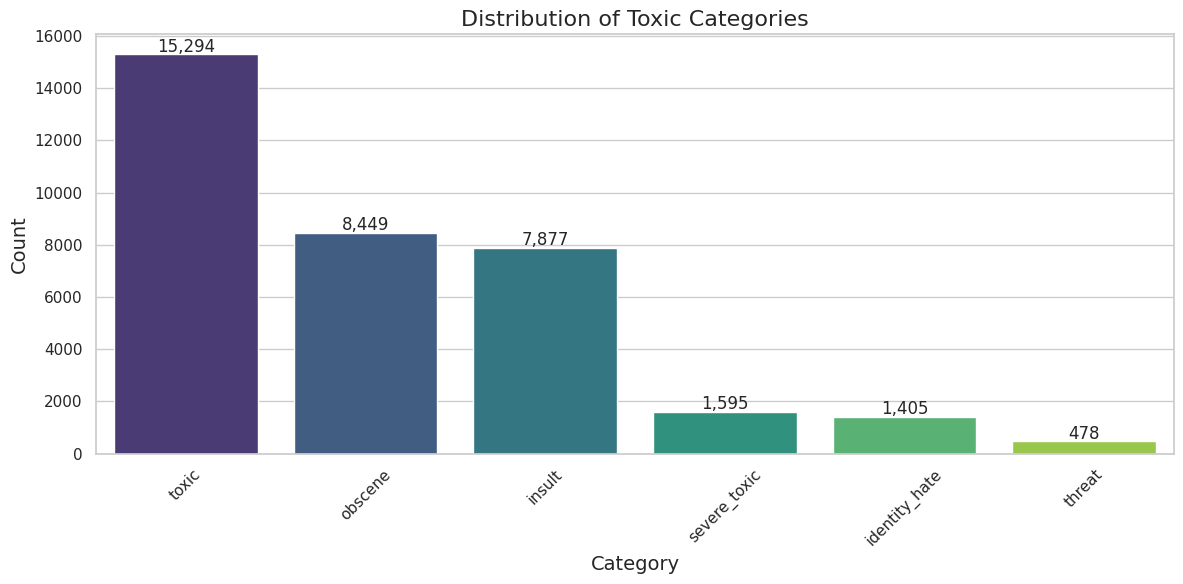

In [8]:
# Analyze the distribution of toxic categories
toxic_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
toxic_counts = train_df[toxic_columns].sum().sort_values(ascending=False)

# Plot the distribution
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=toxic_counts.index, y=toxic_counts.values, palette='viridis')
plt.title('Distribution of Toxic Categories', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)

# Annotate bars with count values
for i, count in enumerate(toxic_counts.values):
    ax.text(i, count + 100, f'{count:,}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

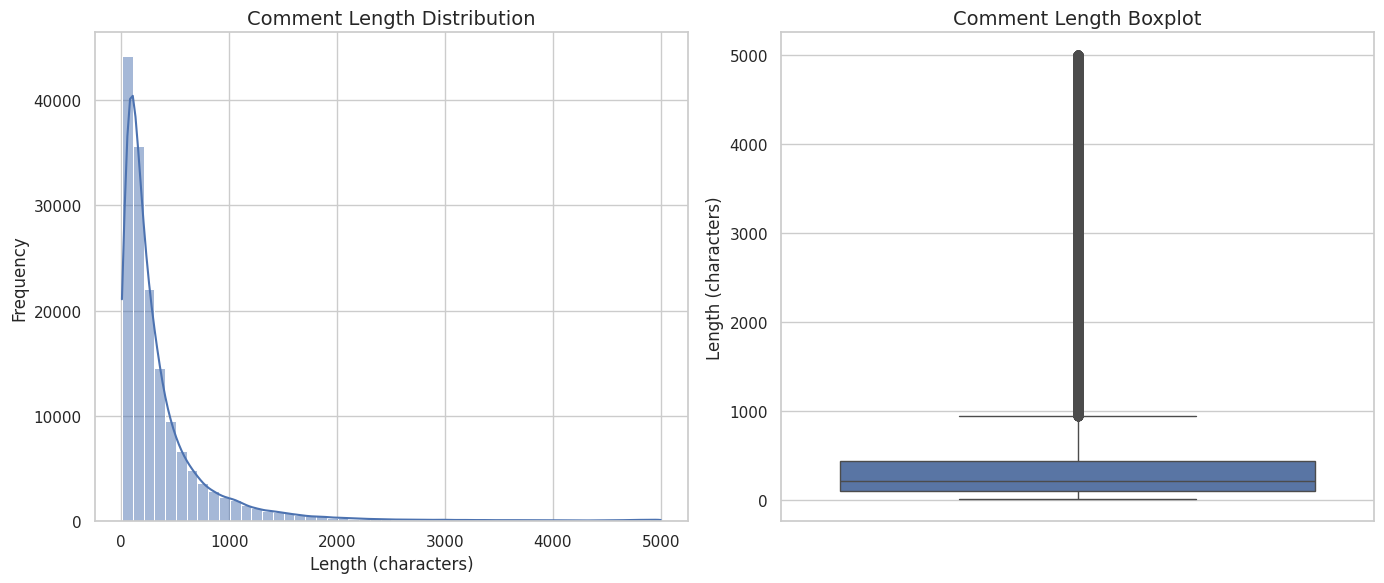

In [9]:
# Analyze comment lengths
train_df['comment_length'] = train_df['comment_text'].apply(len)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(train_df['comment_length'], bins=50, kde=True)
plt.title('Comment Length Distribution', fontsize=14)
plt.xlabel('Length (characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1, 2, 2)
sns.boxplot(y='comment_length', data=train_df)
plt.title('Comment Length Boxplot', fontsize=14)
plt.ylabel('Length (characters)', fontsize=12)
plt.tight_layout()
plt.show()

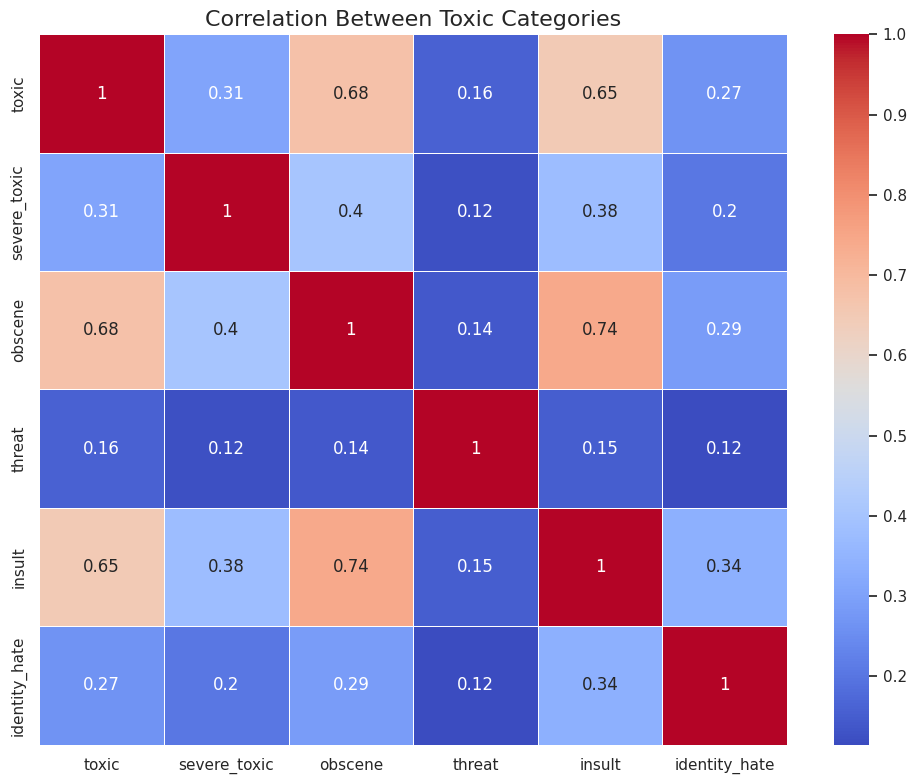

In [12]:
# Correlation between toxic categories
plt.figure(figsize=(10, 8))
sns.heatmap(train_df[toxic_columns].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Between Toxic Categories', fontsize=16)
plt.tight_layout()
plt.show()